<a href="https://colab.research.google.com/github/tylerheadley/Movie-Recommender-NMF/blob/main/MovieRecommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Movie Recommender System
###Shreya Balaji, Tyler Headley, and Bryce Tu Chi

This is our final project for MATH189: Mathematical Data Science & Topic Modeling. Currently a work in progress.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math

To train and expirement with our NMF model, we will use ["Movie Recommender System Dataset"](https://www.kaggle.com/datasets/gargmanas/movierecommenderdataset?select=movies.csv) from Kaggle.

In [2]:
# put dataset into Pandas DataFrames
movies_df = pd.read_csv('https://raw.githubusercontent.com/tylerheadley/Movie-Recommender-NMF/main/Data/movies.csv')
ratings_df = pd.read_csv('https://raw.githubusercontent.com/tylerheadley/Movie-Recommender-NMF/main/Data/ratings.csv')



#Data Exploration#
Now we'll do some data exploration and visualization to get to know our dataset better. We'll start out by taking a look at the sampling distribution for the ratings given to movies in our dataset, which are values from 0.5 to 5.0.

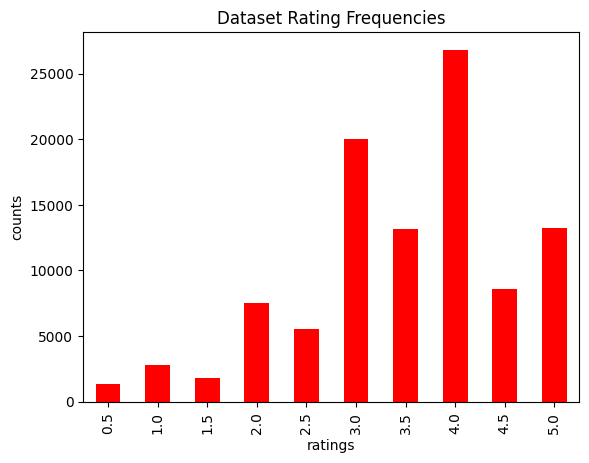

In [3]:
# create bar plot
ratings_df['rating'].value_counts().sort_index().plot(kind="bar", color='red')

# add labels and title
plt.xlabel('ratings')
plt.ylabel('counts')
plt.title('Dataset Rating Frequencies')

plt.show()

Next, we'll dig into the movies dataset and explore what types of movies are present.

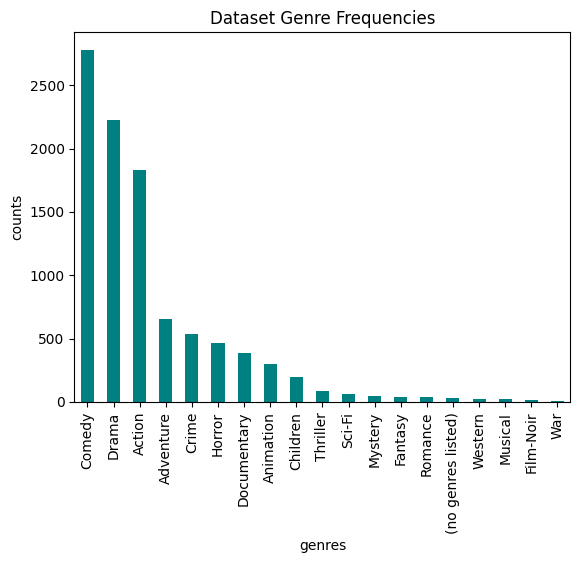

In [4]:
# movies are tagged with multiple genres listed in one column, separated by "|"
categories = movies_df['genres'].str.split("|", expand=True) # create dataframe with a separate column for each genre
category_counts = categories[0].value_counts() # initialize category counts

for i in range(1, categories.shape[1]):
  # if new genre not already in Series, initialize it to zero
  category_counts.add(categories[i].value_counts(), fill_value=0)

# create bar plot
category_counts.plot(kind="bar", color='teal')

# add labels and title
plt.xlabel('genres')
plt.ylabel('counts')
plt.title('Dataset Genre Frequencies')

plt.show()

#Data Processing#
The next step is to prepare the data in the Pandas dataframes for NMF. This means we first need to construct a User-Item Rating Matrix which will be used in the collaborative filtering algorithm.

In [5]:
def dataframesToMatrix(movies_df, ratings_df, validation_partition: float = 0.1):
  '''Function to convert movie and rating dataframes into numpy data matrix for NMF.'''

  # create matrix with dimensions |Users| X |Movies|
  rating_matrix = np.zeros((ratings_df.loc[ratings_df.shape[0] - 1, 'userId'], movies_df.shape[0]))

  # keep track of where ratings are stored in matrix to easily iterate over known ratings later
  rating_indices = []

  # initialize validation set to later assess prediction accuracy
  validation_set = []

  # number of items each user has rated
  item_rating_counts = np.zeros(rating_matrix.shape[0])

  # number of users who have rated each item
  user_rating_counts = np.zeros(rating_matrix.shape[1])

  # for each rating given to a movie by a user, set the entry at the corresponding location in the matrix to that rating
  # otherwise, the entry will remain zero
  for index, row in ratings_df.iterrows():
    userIndex = int(row['userId']) - 1 # 610 users, each with unique IDs from 1 to 610 (no gaps)
    movieIndex = movies_df.index[movies_df['movieId'] == row['movieId']].tolist()[0] # 9742 movies with unique IDs from 1 to 193609 (not consecutive)

    isValidation = (random.random() < validation_partition)
    if isValidation:
      validation_set.append((row['rating'], userIndex, movieIndex))
    else:
      # place rating value at corresponding index in matrix
      rating_matrix[userIndex][movieIndex] = row['rating']

      rating_indices.append((userIndex, movieIndex))

      item_rating_counts[userIndex] += 1
      user_rating_counts[movieIndex] += 1

  return rating_matrix, rating_indices, validation_set, item_rating_counts, user_rating_counts


rating_matrix, rating_indices, validation_set, item_rating_counts, user_rating_counts = dataframesToMatrix(movies_df, ratings_df)

print(rating_matrix)

[[4.  0.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  0.  ... 0.  0.  0. ]]


Sparsity = # non-zero entries / # total entries = $\frac{100836}{610 * 9742}$ = 0.01696827325

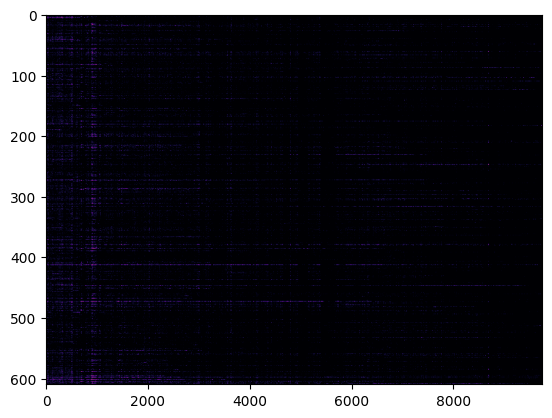

In [6]:
# display values of matrix entries by index
plt.imshow(rating_matrix, aspect='auto', cmap="inferno")
plt.show()

We can see the extreme sparsity of our user-item data matrix, which will mandate use of a specialized form of NMF for Collaborative Filtering so that we can fill in missing values.

In [7]:
# code from Prof Haddock's multiplicative updates tutorial, adapted to work with our data matrix
# we will improve on this algorithm by encouraging the factor matrices to remain sparse
def mult_ups(X, k, M = 10):
  eps_divide = 1e-6                                                 #define a small number to ensure we never divide by 0
  m,N = np.shape(X)                                                 #determine the size of X for initializing A and S

  if M < 1:
    raise Exception("Not a valid number of iterations.")            #error if number of iterations is less than 1

  A = np.abs(np.random.randn(m,k))                                  #initialize factor matrices
  S = np.abs(np.random.randn(k,N))

  errors = [np.linalg.norm(X-A@S,'fro')**2]                          #initialize error array

  for i in range(M):
    A = A*((X@np.transpose(S))/(A@S@np.transpose(S) + eps_divide))  #update for A
    S = S*((np.transpose(A)@X)/(np.transpose(A)@A@S + eps_divide))  #update for S

    errors.append(np.linalg.norm(X-A@S,'fro')**2)                    #record error

  return A, S, errors

P, Q, errors = mult_ups(rating_matrix, 10, M = 150)
X_hat = P@Q

print(errors)

[269529606.5883777, 997997.9828252214, 973096.3300725922, 966252.1652062582, 957892.6038925241, 946943.4844559628, 933298.0220560912, 917539.2872506677, 901433.6258789026, 887621.2915649372, 876952.4545947887, 868709.5447369342, 862089.441120018, 856583.4720930025, 851914.016410605, 847899.2218984434, 844399.4125672946, 841316.1997370519, 838582.5811484412, 836146.5111636074, 833964.448375065, 832002.1329436757, 830231.7414052334, 828633.3554274736, 827195.4106633388, 825908.7122538409, 824760.0673602863, 823733.9052851473, 822813.5904285543, 821982.6990874833, 821228.2279851211, 820541.8815931368, 819919.0685106651, 819355.977273185, 818848.4512435521, 818392.3770740966, 817982.2720440096, 817611.7799684977, 817276.2675008768, 816972.3315367515, 816695.9363469076, 816442.968891657, 816210.3360801504, 815996.2580696607, 815799.3483846616, 815618.0493911239, 815450.5804837348, 815294.6657770321, 815148.1938302255, 815009.6794973171, 814877.9824610539, 814752.377486594, 814632.3087511292

In [8]:
def rmse(R_hat, validation_set):
  validation_set_size = len(validation_set)
  sum = 0
  for rating in validation_set:
    sum += (rating[0] - R_hat[rating[1]][rating[2]])**2

  return math.sqrt(sum/validation_set_size)

In [9]:
# f is the feature matrix dimension
def nmf_cf(R, f, rating_indices, I, U, validation_set, lambda_P = .06, lambda_Q = .06, max_training_round = 10):
  # initialize factor matrices
  P = np.random.rand(R.shape[0], f)
  Q = np.random.rand(f, R.shape[1])

  #define a small number to ensure we never divide by 0
  eps_divide = 1e-6

  # initialize auxiliary matrices (used to store intermediate values)
  UserUP = np.zeros((R.shape[0], f))
  UserDOWN = np.zeros((R.shape[0], f))
  ItemUP = np.zeros((f, R.shape[1]))
  ItemDOWN = np.zeros((f, R.shape[1]))

  training_round = 0

  # keep track of error between actual matrix and predicted values
  errors = [rmse(P@Q, validation_set)]


  # while not converge ???
  while training_round != max_training_round:
    print("training round:", training_round)

    # reset matrices to zero
    UserUP.fill(eps_divide)
    UserDOWN.fill(eps_divide)
    ItemUP.fill(eps_divide)
    ItemDOWN.fill(eps_divide)

    R_hat = P@Q
    for rating in rating_indices:
      # print(rating)
      u = int(rating[0])
      i = int(rating[1])
      # if there is a rating of movie i by user u
      for k in range(f):
        # update auxiliary matrices
        UserUP[u][k] = UserUP[u][k] + Q[k][i] * R[u][i]
        UserDOWN[u][k] = UserDOWN[u][k] + Q[k][i] * R_hat[u][i]
        ItemUP[k][i] = ItemUP[k][i] + P[u][k] * R[u][i]
        ItemDOWN[k][i] = ItemDOWN[k][i] + P[u][k] * R_hat[u][i]

    for u in range(R.shape[0]):
      for k in range(f):
        UserDOWN[u][k] = UserDOWN[u][k] + I[u] * lambda_P * P[u][k]

    # perform multiplicative update for P
    P = P*(UserUP/UserDOWN)

    for i in range(R.shape[1]):
      for k in range(f):
        ItemDOWN[k][i] = ItemDOWN[k][i] + U[i] * lambda_Q * Q[k][i]

    # perform multiplicative update for Q
    Q = Q*(ItemUP/ItemDOWN)

    training_round += 1

    # record error
    errors.append(rmse(P@Q, validation_set))

  return P, Q, errors

P, Q, errors = nmf_cf(rating_matrix, 20, rating_indices, item_rating_counts, user_rating_counts, validation_set, lambda_P = .12, lambda_Q = .12, max_training_round = 20)

print(errors)

training round: 0
training round: 1
training round: 2
training round: 3
training round: 4
training round: 5
training round: 6
training round: 7
training round: 8
training round: 9
training round: 10
training round: 11
training round: 12
training round: 13
training round: 14
training round: 15
training round: 16
training round: 17
training round: 18
training round: 19
[2.057912309757661, 1.5461311959527677, 1.577199887114699, 1.402228606460033, 1.3626205796515563, 1.2999247751630507, 1.2163091396795145, 1.2185493144099036, 1.1145206448286795, 1.1537000895966076, 1.043996935354678, 1.102253408519831, 0.99554886574041, 1.0616257235115458, 0.9625996360368545, 1.0296567450491176, 0.9404395961730055, 1.0045567119229333, 0.9257249416122366, 0.9848634013245249, 0.9161057434393703]


In [10]:
def recommendations(R_hat, R, movies_df, rating_indices, userIndex, num_recommendations = 5):
  imputed_user_preferences = R_hat[userIndex]

  recommendations = []
  for movieIndex in range(len(imputed_user_preferences)):
    if R[userIndex][movieIndex] == 0:
      recommendations.append((imputed_user_preferences[movieIndex], movieIndex))

  recommendations_sorted = sorted(recommendations, key = lambda x: x[0])[::-1]


  return [movies_df.iloc[movie[1]]["title"] for movie in recommendations_sorted][0:num_recommendations]


R_hat = P@Q
print("Known user preferences: ", recommendations(rating_matrix, rating_matrix, movies_df, rating_indices, 0))
print("Our recommendations:", recommendations(R_hat, rating_matrix, movies_df, rating_indices, 0))
print("Standard multiplicative update recommendations (Prof Haddock's mult_ups algorithm):", recommendations(X_hat, rating_matrix, movies_df, rating_indices, 0))

Known user preferences:  ['Andrew Dice Clay: Dice Rules (1991)', 'Bungo Stray Dogs: Dead Apple (2018)', 'Flint (2017)', 'No Game No Life: Zero (2017)', 'Black Butler: Book of the Atlantic (2017)']
Our recommendations: ['The 5th Wave (2016)', 'Another Cinderella Story (2008)', 'Ultimate Avengers 2 (2006)', 'Villain (1971)', 'Match Factory Girl, The (Tulitikkutehtaan tyttö) (1990)']
Standard multiplicative update recommendations (Prof Haddock's mult_ups algorithm): ['Aliens (1986)', 'Terminator 2: Judgment Day (1991)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', 'Saving Private Ryan (1998)', 'Sixth Sense, The (1999)']


training round: 0
training round: 1
training round: 2
training round: 3
training round: 4
training round: 5
training round: 6
training round: 7
training round: 8
training round: 9
training round: 10
training round: 11
training round: 12
training round: 13
training round: 14
training round: 15
training round: 16
training round: 17
training round: 18
training round: 19
training round: 20
training round: 21
training round: 22
training round: 23
training round: 24
training round: 0
training round: 1
training round: 2
training round: 3
training round: 4
training round: 5
training round: 6
training round: 7
training round: 8
training round: 9
training round: 10
training round: 11
training round: 12
training round: 13
training round: 14
training round: 15
training round: 16
training round: 17
training round: 18
training round: 19
training round: 20
training round: 21
training round: 22
training round: 23
training round: 24
training round: 0
training round: 1
training round: 2
training round: 

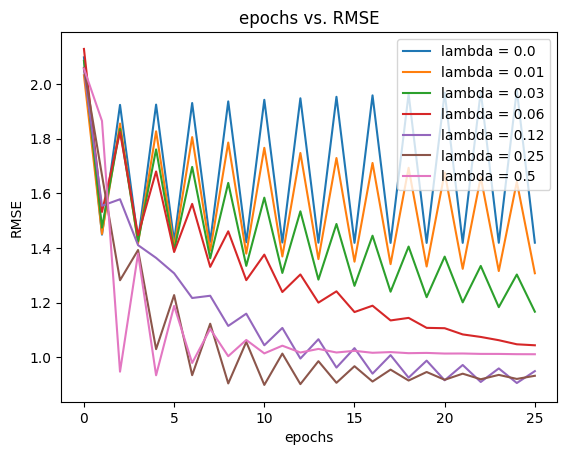

In [11]:
# error_by_lambda = []
for lambda_PQ in [0.0, .01, .03, .06, .12, .25, .5]:
  P, Q, errors = nmf_cf(rating_matrix, 20, rating_indices, item_rating_counts, user_rating_counts, validation_set, lambda_P = lambda_PQ, lambda_Q = lambda_PQ, max_training_round = 25)
  # error_by_lambda.append(errors)

  plt.plot(range(len(errors)), errors, label=f"lambda = {lambda_PQ}")

# add labels and title
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.title('epochs vs. RMSE')
plt.legend(loc='upper right')

plt.show()
